## Test mrcn inference

In [2]:
import os
import os.path
import sys
import numpy as np
import argparse
import torch
from scipy.misc import imread

# add matplotlib before cv2, otherwise bug
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10., 8.)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# add paths
sys.path.insert(0, '../tools')
import _init_paths
from model.nms_wrapper import nms
from mrcn import inference, inference_no_imdb

In [3]:
# mrcn inference instance
parser = argparse.ArgumentParser()
parser.add_argument('--imdb_name', default='coco_minus_refer', help='image databased trained on.')
parser.add_argument('--net_name', default='res101')
parser.add_argument('--iters', default=1250000, type=int)
parser.add_argument('--tag', default='notime')
args = parser.parse_args('')
mrcn = inference.Inference(args)
imdb = mrcn.imdb

Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [4, 8, 16, 32],
 'DATA_DIR': '/playpen10/licheng/Documents/refer_cvpr2018/MattNet/pyutils/mask-faster-rcnn/data',
 'EXP_DIR': 'res101',
 'MASK_SIZE': 14,
 'MATLAB': 'matlab',
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POOLING_ALIGN': False,
 'POOLING_MODE': 'crop',
 'POOLING_SIZE': 7,
 'RESNET': {'FIXED_BLOCKS': 1, 'MAX_POOL': False},
 'RNG_SEED': 3,
 'ROOT_DIR': '/playpen10/licheng/Documents/refer_cvpr2018/MattNet/pyutils/mask-faster-rcnn',
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'MODE': 'nms',
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'gt',
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
          'RPN_TOP_N': 5000,
          'SCALES': [60

In [4]:
# demo image
img_path = '../pyutils/mask-faster-rcnn/data/demo/004545.jpg'

## 1. test predict()

In [7]:
# predict
scores, boxes = mrcn.predict(img_path)

# nms and threshold
CONF_THRESH = 0.65
NMS_THRESH = 0.3
cls_to_dets = {}
for cls_ind, cls in enumerate(imdb.classes[1:]):
    cls_ind += 1 # because we skipped background
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes, 
                      cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(torch.from_numpy(dets), NMS_THRESH)
    dets = dets[keep.numpy(), :] 
    inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
    dets = dets[inds, :]
    cls_to_dets[cls] = dets
    
# compute cls_to_masks
cls_to_masks = {}
for cls, dets in cls_to_dets.items():
    if dets.shape[0] > 0:
        label = mrcn.imdb._class_to_ind[cls]
        labels = np.array([label] * dets.shape[0], dtype=np.int)
        masks, rles = mrcn.boxes_to_masks(img_path, dets[:, :4], labels)
        cls_to_masks[cls] = masks*255

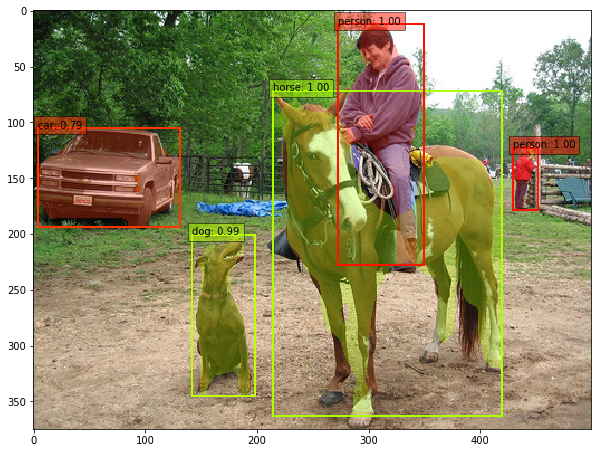

In [8]:
# visualize
colors = plt.cm.hsv(np.linspace(0, 1, imdb.num_classes)).tolist()
im = imread(img_path)
plt.imshow(im)
currentAxis = plt.gca()
for cls, dets in cls_to_dets.items():
    for i in range(dets.shape[0]):
        bbox = dets[i, :4]
        score = dets[i, -1]
        display_txt = '%s: %.2f'%(cls, score)
        coords = (bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1
        color = colors[imdb.classes.index(cls)]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(bbox[0], bbox[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})  
        # add mask
        m = cls_to_masks[cls][i] > 122. # uint8
        color_mask = np.random.random((1,3)).tolist()[0]
        img = np.ones( (m.shape[0], m.shape[1], 3) )
        for i in range(3):
            img[:,:,i] = color[i]
        currentAxis.imshow(np.dstack( (img, m*0.3) ))

## 2. test extract_head(), head_to_prediction()

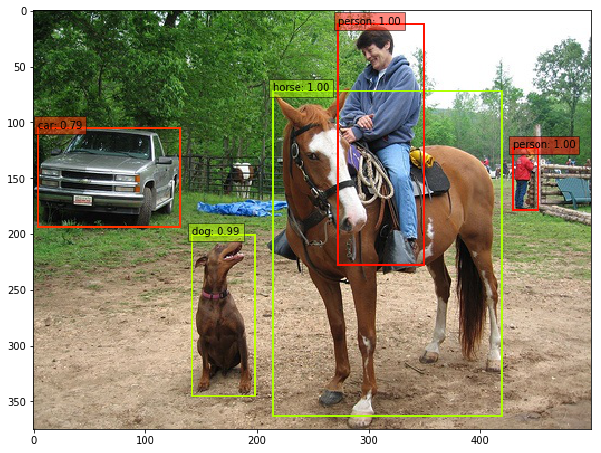

In [9]:
# predict
head, im_info = mrcn.extract_head(img_path)
scores, boxes = mrcn.head_to_prediction(head, im_info)

# nms and threshold
CONF_THRESH = 0.65
NMS_THRESH = 0.3
cls_to_dets = {}
for cls_ind, cls in enumerate(imdb.classes[1:]):
    cls_ind += 1 # because we skipped background
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes, 
                      cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(torch.from_numpy(dets), NMS_THRESH)
    dets = dets[keep.numpy(), :] 
    inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
    dets = dets[inds, :]
    cls_to_dets[cls] = dets
    
# visualize
colors = plt.cm.hsv(np.linspace(0, 1, imdb.num_classes)).tolist()
im = imread(img_path)
plt.imshow(im)
currentAxis = plt.gca()
for cls, dets in cls_to_dets.items():
    for i in range(dets.shape[0]):
        bbox = dets[i, :4]
        score = dets[i, -1]
        display_txt = '%s: %.2f'%(cls, score)
        coords = (bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1
        color = colors[imdb.classes.index(cls)]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(bbox[0], bbox[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})  

## 3. test box_to_fc(); run 